In [2]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from xgboost import XGBClassifier


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.models import resnet18, ResNet18_Weights

from tqdm import tqdm

# Ensuring reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

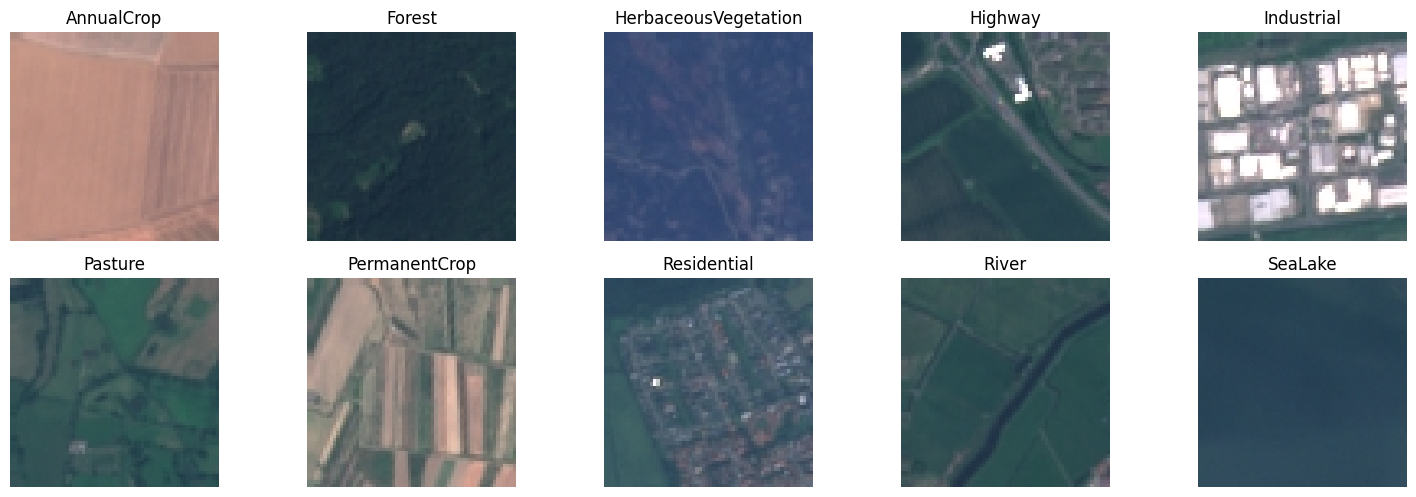

In [5]:
data_dir = '../data/EuroSAT_RGB/'
label_names = sorted(os.listdir(data_dir))

plt.figure(figsize=(15, 10))
for i, label in enumerate(label_names):
    filename = os.listdir(os.path.join(data_dir, label))[0]
    path = os.path.join(data_dir, label, filename)
    img = Image.open(path)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

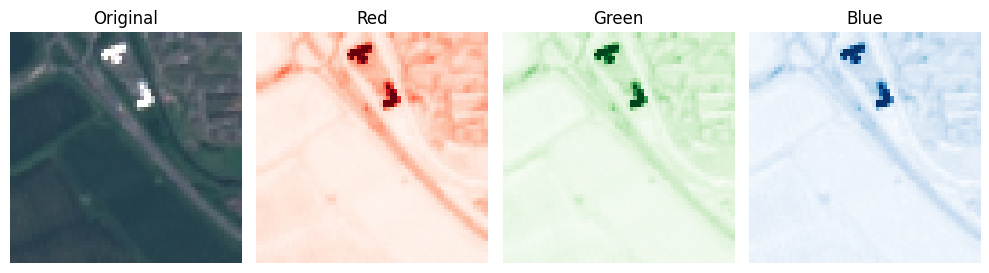

In [6]:
label = label_names[3]
path = os.path.join(data_dir, label, os.listdir(os.path.join(data_dir, label))[0])
img = Image.open(path).convert("RGB")
channels = img.split()
titles = ["Original", "Red", "Green", "Blue"]
cmaps = [None, "Reds", "Greens", "Blues"]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img if i == 0 else channels[i - 1], cmap=cmaps[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
split = [0.7, 0.15, 0.15]  # train, val, test
# this dictionary creates an id for each label
label2idx = {label: i for i, label in enumerate(label_names)}

# we store the filenames and labels in lists
files, targets = [], []
for label in label_names:
    label_files = glob(os.path.join(data_dir, label, "*.jpg"))
    files += label_files
    targets += [label2idx[label]] * len(label_files)

# we split the lists into training, validation, and test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, targets, train_size=split[0], stratify=targets, random_state=1)

val_size = split[1] / (split[1] + split[2])  # proportion of val in temp
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, train_size=val_size,
    stratify=temp_labels, random_state=1)

In [8]:
def extract_features_from_path(img_path):
    img = Image.open(img_path).convert('RGB')
    arr = np.array(img)
    features = []
    for i in range(3):  # R, G, B
        ch = arr[:, :, i]
        features.append(ch.mean())
        features.append(ch.std())
        features.append(ch.min())
        features.append(ch.max())
    return features  # 12 features

X_train = np.array([extract_features_from_path(p) for p in train_files])
X_val   = np.array([extract_features_from_path(p) for p in val_files])
X_test  = np.array([extract_features_from_path(p) for p in test_files])

y_train = np.array(train_labels)
y_val   = np.array(val_labels)
y_test  = np.array(test_labels)

# For the xgboost model, we combine training and validation
X_trainval = np.concatenate([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

In [10]:
# the parameters to sample from to try out
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
}

clf = RandomizedSearchCV(XGBClassifier(eval_metric='mlogloss'), 
                   param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, n_iter=30)

clf.fit(X_trainval, y_trainval)
print("Best parameters:", clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1}


In [11]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:  {f1:.4f}")

Accuracy:  0.8220
Precision: 0.8130
Recall:    0.8155
F1 score:  0.8138


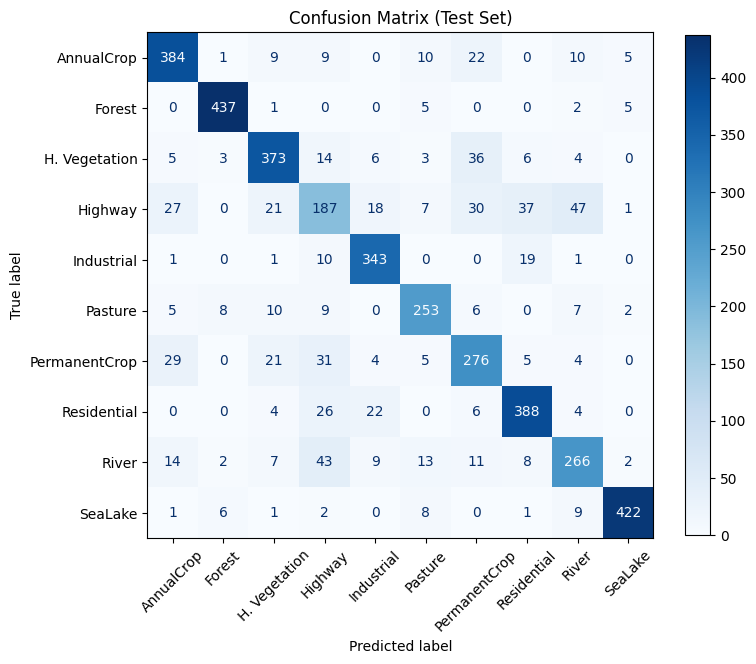

In [13]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

short_labels = [ln.replace("HerbaceousVegetation", "H. Vegetation") 
               for ln in label_names]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_labels)
fig, ax = plt.subplots(figsize=(8, 8))
im = disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)
cbar = fig.colorbar(im.im_, ax=ax, shrink=0.7)
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.DEFAULT

model = resnet18(weights=weights)
batch_size = 16

# Replace the classifier (EuroSAT has 10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/nissim/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 38.0MB/s]


In [15]:
class EuroSATDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, self.labels[idx]


class RandomFixedRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)
    
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomFixedRotation(),  # Only 90, 180, 270
    transforms.ToTensor(),
    # The ResNet is pretrained on ImageNet
    # these are the stats of the ImageNet data
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_data = EuroSATDataset(train_files, train_labels, train_transform)
val_data = EuroSATDataset(val_files, val_labels, val_transform)
test_data = EuroSATDataset(test_files, test_labels, val_transform)

train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=0)
val_loader   = DataLoader(val_data, batch_size=batch_size, num_workers=0)
test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=0)

In [16]:
learning_rate = 0.001
momentum = 0.9

# the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Define the number of epochs
epochs = 30
# Number of epochs without improvement of validation loss for early stop 
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Epoch 1/30: Train Loss 0.4768, Acc 0.8438 | Val Loss 0.1702, Acc 0.9437


Epoch 2/30: Train Loss 0.2526, Acc 0.9169 | Val Loss 0.1849, Acc 0.9383


Training:  53%|█████▎    | 629/1182 [00:28<00:30, 17.92it/s]

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()